In [23]:
# Do we actually need all this using statements?
# Potentially, they are automatically included when loading RandomMeas ?
using Random # Shall we move it to some script file? The user does not need it explicitly?
using ITensors, ITensorMPS
using RandomMeas
using ProgressBars # Shall we move it to some script file? The user does not need it explicitly?

## Shallow Shadows 

### Introduction
For a given ensemble of random unitaries $\{u\}$, the measurement or shadow channel $\mathcal{M}$ is defined as $\rho \rightarrow \mathcal{M}(\rho)=\mathbb{E}_u \left[  \sum_s \bra{s}\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u\right]$ where $\mathbb{E}_u$ denotes the average over the random unitary ensemble. For certain ensembles, in particular local (single-qubit) and global (N-qubit) unitaries from unitary 2-designs, the channel and its inverse $\mathcal{M}^{-1}$ can be computed analytically (Huang et al., Nat. Phys. 2020). We can then use to construct classical shadows for arbitrary input states $\rho$: $\hat{\rho}=\mathcal{M}^{-1}(u^\dagger \ket{s}\bra{s}u)$ where $s$ is the outcome bitstring  of a single computational basis measurement performed on $u\rho u^\dagger$.

For more general ensembles of random unitaries, we need to learn the channel $\mathcal{M}$, then invert it to form shadows and obtain a randomized measurement protocol.

This notebook illustrates this for case of random unitaries formed by shallow random quantum circuits [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), [Akhtar et al., Quantum 7, 1026 (2023)](https://quantum-journal.org/papers/q-2023-06-01-1026) and [Hu et al., arXiv:2402.17911](https://arxiv.org/abs/2402.17911). Importantly, we use the property that shallow random quantum circuits are locally scrambling circuits. This allows us to learn a represenatioin of the channel from evaluating its action on single initial product state  [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027).

In [24]:
#TODO: Do we need to cite the Eisert paper? 
#TODO: Is the last sentence correct

In [25]:
N = 12 # System size
ξ = siteinds("Qubit", N; addtags="output"); #site indices of the qubits in the system

We begin by picking a set of $N_u$ shallow circuits and calculate numerically the measurement channel $\sigma_0=\mathcal{M}(\rho_0)$ from MPS simulations. Here, $\rho_0=\ket{0}\bra{0}$. Note that alternatively, one could consider measuring an approximate representation of the channel experimentally ([Hu et al., arXiv:2402.17911](https://arxiv.org/abs/2402.17911)).

In [27]:
Nu = 1000 # Number of unitaries
ψ0 = MPS(ξ,["Dn" for n in 1:N]  ); # Initial probe state
ρ0 = outer(ψ0',ψ0); # Initial density matrix of the probe state TODO: Check if this is actually used somewhere

random_unitaries = Vector{Vector{ITensor}}()
depth = 2
for r in 1:Nu # For each unitary u, we generate a random circuit of depth 2
    push!(random_unitaries,RandomCircuit(ξ,depth)) 
end
output_states_ensemble = EvaluateMeasurementChannel(ψ0,random_unitaries); # For each unitary u, we evaluate the measurement channel output_state_u = M_u(\psi_0) = \sum_s \bra{s}\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u. We obtain a vector [M_u(\psi_0)]_u. TODO: Why do we use \psi_0 and not \rho_0? Does EvaluateMeasurementChannel accept density matrix MPO as input, as suggested by the notation?

#TODO: shall we rename the function to follow our/julia naming conventions https://docs.sciml.ai/SciMLStyle/stable/#General-Naming-Principles ? 
# shall we rename M? M is the measurement channel, but here we construct M(rho_0). I maded an attempt

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


1000-element Vector{MPO}:
 MPO
[1] ((dim=2|id=803|"Qubit,Site,n=1,output")', (dim=2|id=803|"Qubit,Site,n=1,output"), (dim=4|id=885|"Link,n=1"))
[2] ((dim=2|id=678|"Qubit,Site,n=2,output")', (dim=2|id=678|"Qubit,Site,n=2,output"), (dim=8|id=772|"Link,n=1"), (dim=4|id=885|"Link,n=1"))
[3] ((dim=2|id=683|"Qubit,Site,n=3,output")', (dim=2|id=683|"Qubit,Site,n=3,output"), (dim=32|id=44|"Link,n=1"), (dim=8|id=772|"Link,n=1"))
[4] ((dim=2|id=730|"Qubit,Site,n=4,output")', (dim=2|id=730|"Qubit,Site,n=4,output"), (dim=16|id=886|"Link,n=1"), (dim=32|id=44|"Link,n=1"))
[5] ((dim=2|id=504|"Qubit,Site,n=5,output")', (dim=2|id=504|"Qubit,Site,n=5,output"), (dim=64|id=71|"Link,n=1"), (dim=16|id=886|"Link,n=1"))
[6] ((dim=2|id=60|"Qubit,Site,n=6,output")', (dim=2|id=60|"Qubit,Site,n=6,output"), (dim=16|id=66|"Link,n=1"), (dim=64|id=71|"Link,n=1"))
[7] ((dim=2|id=386|"Qubit,Site,n=7,output")', (dim=2|id=386|"Qubit,Site,n=7,output"), (dim=64|id=557|"Link,n=1"), (dim=16|id=66|"Link,n=1"))
[8] ((dim=2|id=

In [28]:
nsweeps = 4 # Number of sweeps for the fitting 
χ = 4 # Bond dimension of the mpo fitted to output state of the measurement channel applied to \psi_0
σ0 = FitChannelMPO(output_states_ensemble,χ,nsweeps);

# TODO: Do we fit \sigma_0 = \sum_U M_U(\psi_0)? Then, I would not call it FitChannelMPO but fit_output_mpo or something like that. 
# From the naming, I thought you get a (super) MPO representation of M, but you get an MPO rep of the output state, or right?
# TODO: If sigma0 is the fitted output state and not the fitted channel, also the documentation of the method needs to be adjusted.

#TODO: It outputs a negative lower bound to the distance. Is this meaningful? Should just say 0 if the lower bound is negative? Why is a lower bound relevant at all? 
#TODO: can we also output actual distance to the emperical output state of \sum_U M_U(\psi_0)? Can we somehow tell whether the fitting worked or not? and give advice whether nsweeps and/or χ should be increased?
#TODO: There appear multiple progress bars. Shall we just have one?

Lower bound to distance 0.001909824689484759
Lower bound to distance -0.0003267417810943963
Lower bound to distance -0.00032679238436308624
Lower bound to distance -0.000326814743518088
Lower bound to distance -0.00032682178906367636


### Inverting the channel
Now we can then find the inverse map $\mathcal{M}^{-1}(\rho)=\sum_A d_A \rho_A$, such that $\mathcal{M}^{-1}(\mathcal{M})\approx\mathbf{1}$. This is based on automatic-differentation library Zygote and minimizing the cost function $||\rho_0-\mathcal{M}^{-1}(\sigma_0)||^2=||\rho_0-\mathcal{M}^{-1}(\mathcal{M}(\rho_0))||^2$, where the vector $d$ is parametrized as MPS of bond dimension $\chi$

In [29]:
# TODO: The inverse channel, in general, is not uniquely determined by σ0 and \rho0. We need (a complete basis) of input states. I guess we use the local invariance property. Is a single state enough?
# We should  explain how we obtain the representation $\mathcal{M}^{-1}(\rho)=\sum_A d_A \rho_A$. Perhaps we should do this right in the very beginning.

In [30]:
#TODO is it necessry to have chi and nsweeps the same values as in the fitting? if not, I would redefine them. 

d = InversionChannel(ρ0,σ0,χ,nsweeps);

#TODO can we find a better and more informative name for d? e.g. inverse_channel
#TODO can we rename InversionChannel to something more descriptive? e.g. invert_channel or something like that ?
#TODO what is the output loss? How do we know whether the inversion was successfull?

sweep 1 loss 0.052410410913526606
sweep 2 loss 0.04729055163599594
sweep 3 loss 0.04523150930407749
sweep 4 loss 0.04478359461864634


## Simulated experiment
We are ready to perform an experiment on a unknown state $\psi$, build shadows as MPO and estimate expectation values.

In [33]:
circuit = RandomCircuit(ξ,depth)
ψ = apply(circuit,ψ0); # We construct some random pure state \psi, our simulated experimental (unknown) state

We perform random measurements in a simulated quantum device.

In [38]:
NM=10
measurement_data = Array{Int,3}(undef,Nu,NM,N)
@showprogress dt=1 for r in 1:Nu
    measurement_data[r,:,:] = get_RandomMeas(ψ,random_unitaries[r],NM) #data acquisition in simulated quantum device
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


We aim to estimate XX correlations. We construct the corresponding MPOs and compute the exact expectation values.

In [49]:
O = Vector{MPO}()
for i in 1:N-1
    ampo = AutoMPO()
    ampo .+= "X", i,"X",i+1
    push!(O,MPO(ampo,ξ))
end

O_exact = Vector{Float64}()
for o in O
    push!(O_exact,real(inner(ψ',o,ψ)))
end

We construct classical shadows and estimate the expectation values.

In [42]:
O_est = Vector{Float64}(undef,N-1);
@showprogress dt=1 for r in 1:Nu
            shadow = get_ShallowShadow(measurement_data[r,:,:],random_unitaries[r],d,ξ)
            for m in 1:NM
               for i in 1:N-1
                    O_est[i] += real(inner(O[i],shadow[m]))/Nu/NM
                end 
            end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


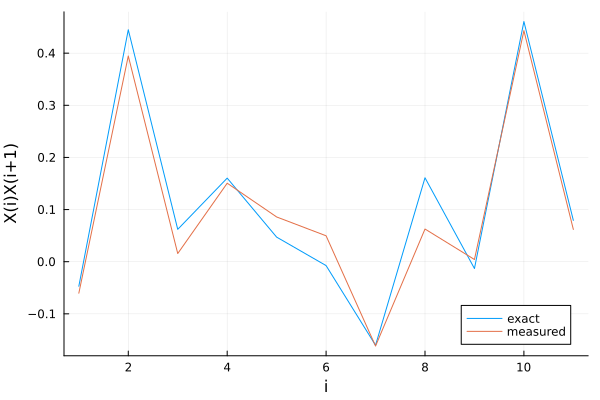

In [50]:
using Plots
plot(O_exact,label="exact")
plot!(O_est,label="measured")
xlabel!("i")
ylabel!("X(i)X(i+1)")